In [ ]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [80]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import ogr
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona

Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [4]:
#dc.list_measurements()

In [81]:
#Use this if you want to specify a shapefile
#open shapefile and retrieve extents
vec_fname = '/g/data/r78/lxl554/hovmoller/goolwa_barrage1.shp'
src = fiona.open(vec_fname)
src[0]['geometry']['coordinates']
#print map_coords
#print lat_min
#print lat_max

[(138.8007303447449, -35.51815334458937, 0.0),
 (138.8079249114791, -35.52494393953098, 0.0),
 (138.8150522902245, -35.52678110419613, 0.0),
 (138.8244223839475, -35.52755355174274, 0.0)]

## Retrieve surface reflectance data


In [6]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Define spatial range if not already defined by polygon above

lat_max = -18.13
lat_min = -18.15
lon_max = 140.83
lon_min = 140.87


#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-07-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'


In [7]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [ ]:
#need to put in NBR

In [8]:
#load sensor specific band adjustment tuples for TSS and brightness

In [9]:
#load sensor specific band adjustment tuples for TSS 
ls5_tss_constant = 3983
ls5_tss_exponent = 1.6246
ls7_tss_constant = 3983
ls7_tss_exponent = 1.6246
ls8_tss_constant = 3957
ls8_tss_exponent = 1.6436

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [10]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day'
                   )

sensor1_pq = dc.load(product= sensor1+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day', fuse_func=pq_fuser
                   )
            

In [11]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [12]:
sensor1_nbar.dims

Frozen(SortedKeysDict(OrderedDict([('time', 133), ('y', 101), ('x', 176)])))

In [13]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [14]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    #sensor1_rsindex['TSS'] = ((sensor1_nbar['green']+sensor1_nbar['red'])/2)
    #Need this to reference into a tuple - Check with Damien    
    sensor1_rsindex['TSS'] = (ls8_tss_constant*((sensor1_nbar['green']+sensor1_nbar['red'])/20000)**ls8_tss_exponent)

In [15]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor2_pq = dc.load(product= sensor2+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day', fuse_func=pq_fuser)
                   

In [16]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [17]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [18]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    #sensor2_rsindex['TSS'] = ((sensor2_nbar['green']+sensor2_nbar['red'])/2)
    sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [19]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch), 
                   measurements = bands_of_interest,
                   group_by='solar_day')
                   
sensor3_pq = dc.load(product= sensor3+'_pq_albers', 
                   x=(lon_min, lon_max), y=(lat_max, lat_min), 
                   time = (start_of_epoch, end_of_epoch),
                   group_by='solar_day', fuse_func=pq_fuser)

In [20]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [21]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud', 
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
#nir = sensor1_nbar.nir.where(sensor1_nbar.nir != sensor1_nbar.nir.attrs['nodata'])
#red = sensor1_nbar.red.where(sensor1_nbar.red != sensor1_nbar.red.attrs['nodata'])
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [22]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    #sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    #sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)
    sensor3_rsindex['TSS'] = (ls5_tss_constant*((sensor3_nbar['green']+sensor3_nbar['red'])/20000)**ls5_tss_exponent)


## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [23]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean_sorted = nbar_clean.isel(time=time_sorted)

all_tss = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss.time.argsort()
all_tss_sorted = all_tss.isel(time=time_sorted)

all_ndvi = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi.time.argsort()
all_ndvi_sorted = all_ndvi.isel(time=time_sorted)

The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

## Plotting a multi-band image

In [24]:
d = nbar_clean_sorted.drop('red')
rgb = d.to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('time', 'y', 'x', 'color')
print 'The number of time slices at this location is' 
print rgb.shape[0]

The number of time slices at this location is
1283


<IPython.core.display.Javascript object>


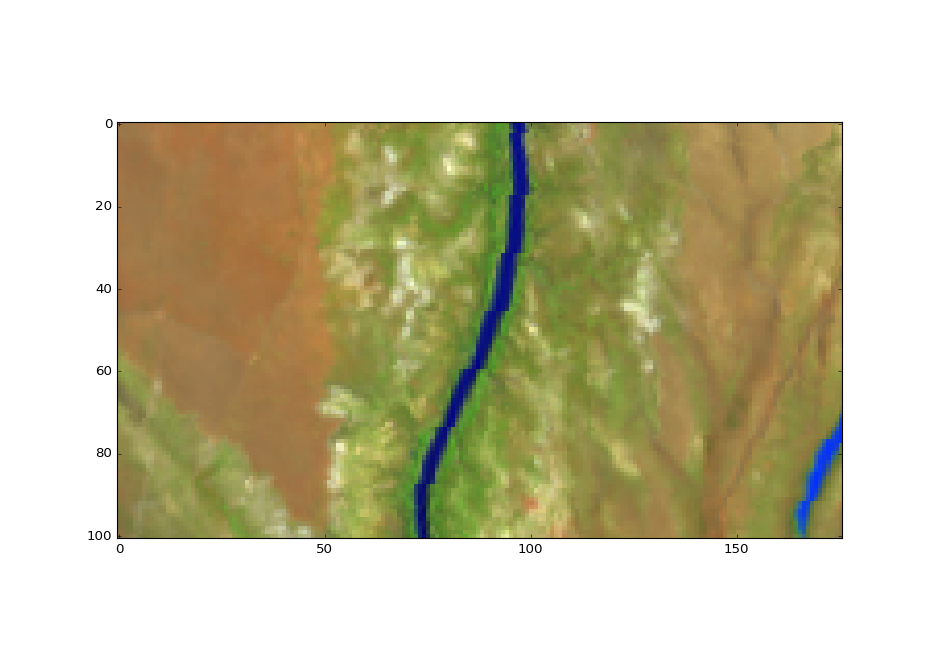

<xarray.DataArray 'time' ()>
numpy.datetime64('2016-05-28T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2016-05-28


In [25]:
#Select time slice of interest
time_slice = 1282


fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize=(11.69,8.27))
date_ = rgb.time[time_slice]
print date_.astype(datetime64)
imshow(scaled.isel(time = time_slice), interpolation = 'nearest')

<IPython.core.display.Javascript object>


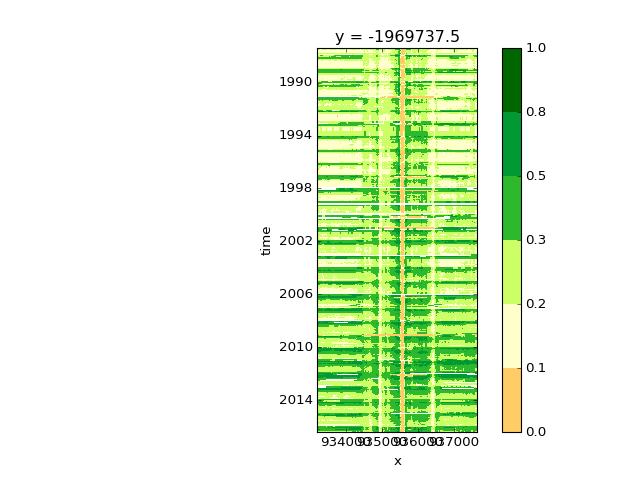

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [26]:
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure()
plt.imshow(scaled.isel(time=time_slice))
#plt.scatter(x=[x], y=[y], c='r')

plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

In [27]:
x, y

(94, 36)

In [29]:
#Define coordinates of interest
xdim = x
ydim = y
#xdim2 = 160
#ydim2 = 88

tss_min = 0
tss_max = 2000
fig, figsize=(11.69,8.27)
plt.scatter(x=[xdim], y=[ydim], c='r')
#plt.scatter(x=[xdim2], y=[ydim2], c='b')

#plt.plot([0, all_ndvi_sorted.shape[2]], [ydim,ydim], 'aquamarine')
plt.plot([xdim,xdim], [0, all_ndvi_sorted.shape[1]], 'aquamarine')

ndvi_cmap = mpl.colors.ListedColormap(['#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])

ndvi_bounds = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
imshow(scaled.isel(time = time_slice))
#plt.plot(map_coords[0],map_coords[3], 'b')
#print map_coords

In [30]:
#View as a Hovmoller plot for the y axis)
all_ndvi_sorted.isel(#x=[xdim],
                     y=[ydim]
                     ).plot(norm= ndvi_norm, cmap = ndvi_cmap, yincrease = False)
#plt.plot([0, all_ndvi_sorted.shape[2]], [time_slice,time_slice], 'r')

<IPython.core.display.Javascript object>


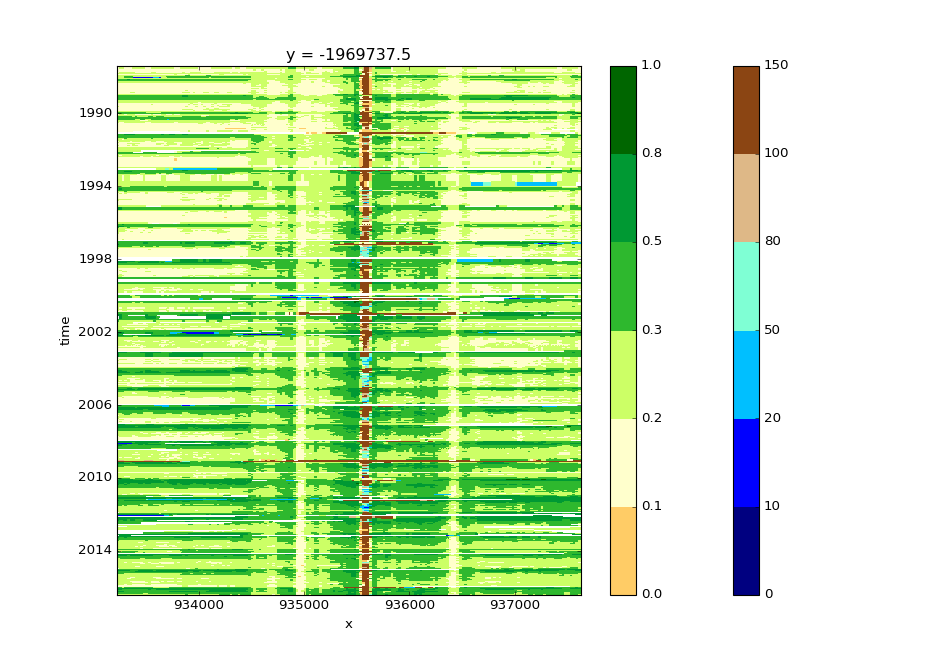

In [31]:
fig = plt.figure(figsize=(11.69,8.27))

water_only = all_tss_sorted.where(nbar_clean_sorted['swir1']<1000)
water_only.isel(#x=[xdim],
                     y=[ydim]
                     ).plot(cmap = tss_cmap, norm = tss_norm, yincrease = False)
land_only = all_ndvi_sorted.where(nbar_clean_sorted['swir1']>1000)
land_only.isel(#x=[xdim],
                     y=[ydim]
                     ).plot(cmap = ndvi_cmap, norm = ndvi_norm, yincrease = False)

## Pixel drill

<IPython.core.display.Javascript object>


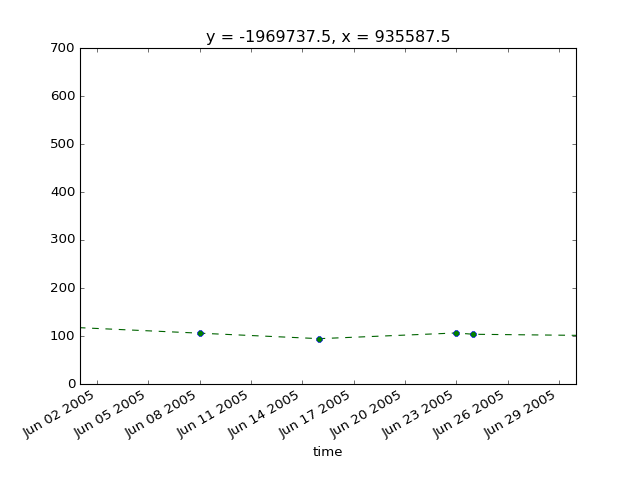

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


['2005-06-01', '2005-06-30', 0, 700]

In [64]:
#Use this plot to visualise TSS time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure()


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

firstyear = '2005-06-01'
lastyear = '2005-06-30'
water_only.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'darkgreen', marker = '8', mec = 'b', mfc ='g')
#water_only.isel(x=[xdim2],y=[ydim2]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,0, 700])

<IPython.core.display.Javascript object>


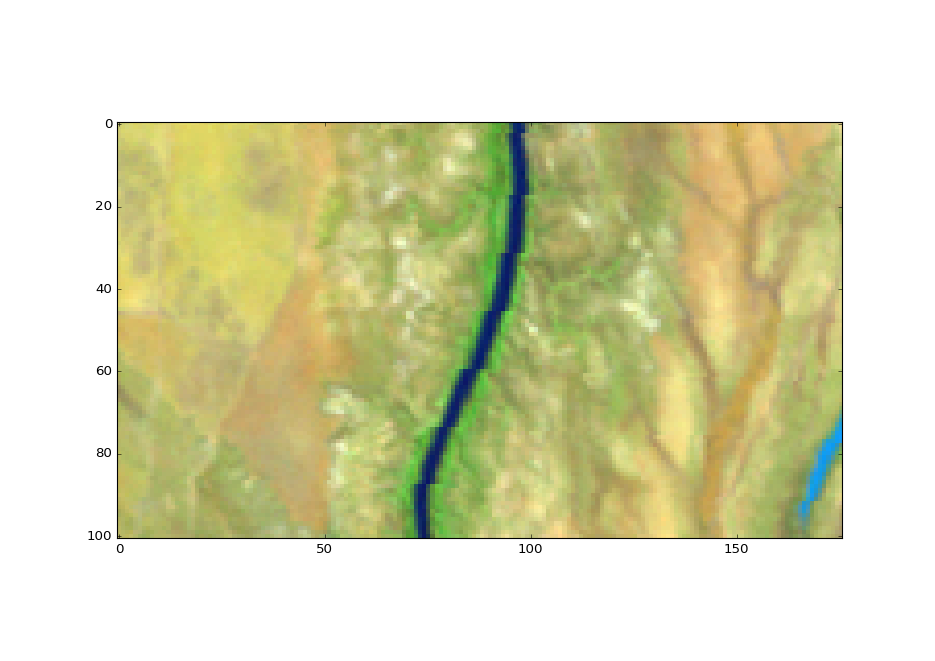

2005-06-24


In [78]:
#Select time slice of interest
time_slice = matplotlib.dates.num2date(time_int).date()


fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize=(11.69,8.27))
print time_slice
imshow(scaled.sel(time = time_slice), interpolation = 'nearest')

In [77]:
time_slice

datetime.date(2005, 6, 24)

In [75]:
matplotlib.dates.num2date(time_int).date()


datetime.date(2005, 6, 24)

['2006', '2010', 0, 1]

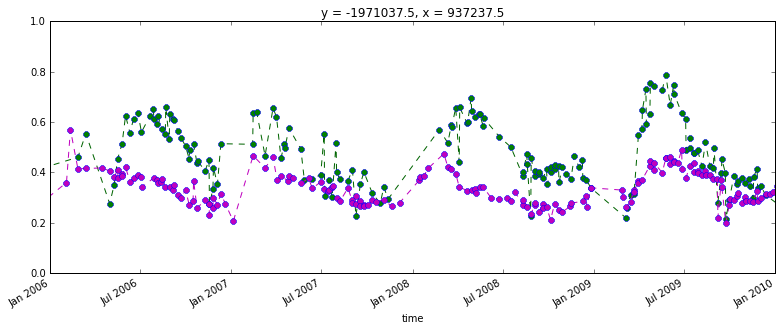

In [37]:
#Use this plot to visualise NDVI time series
#Use this plot to visualise TSS time series
fig = plt.figure(figsize=(13,5))
firstyear = '2006'
lastyear = '2010'
land_only.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'darkgreen', marker = '8', mec = 'b', mfc ='g')
land_only.isel(x=[xdim2],y=[ydim2]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,0, 1])

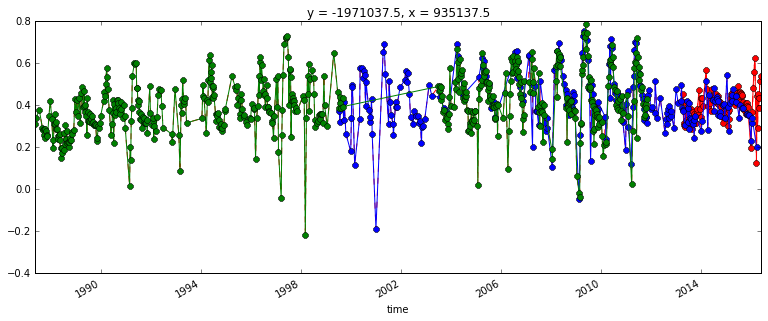

In [40]:
#this plot shows NDVI per sensor
fig = plt.figure(figsize=(13,5))

all_ndvi_sorted.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r')
sensor1_rsindex['NDVI'].isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(c = 'r', marker = '8')
sensor2_rsindex['NDVI'].isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(c  = 'b', marker = '8')
sensor3_rsindex['NDVI'].isel(x=[xdim],y=[ydim]).dropna('time', how = 'any').plot(c = 'g', marker = '8')


<xarray.DataArray 'time' ()>
numpy.datetime64('2016-05-28T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2016-05-28


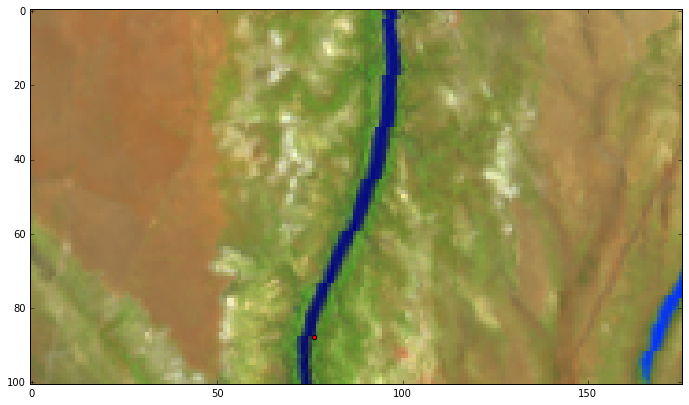

In [58]:
fig = plt.figure(figsize=(11.69,8.27))
time_slice = 1282
plt.scatter(x=[xdim], y=[ydim], c='r')
date_ = rgb.time[time_slice]
print date_.astype(datetime64)
imshow(scaled.isel(time = time_slice), interpolation = 'nearest')
#sensor1_pq.pixelquality.isel(time = time_slice).plot()

In [ ]:
fig = plt.figure(figsize=(11.69,8.27))
#time_slice = 9
print scaled.time[time_slice]
imshow(scaled.isel(time = time_slice), interpolation = 'nearest')
#sensor1_pq.pixelquality.isel(time = time_slice).plot()

In [ ]:
#Shows syntax for multi panel plot
'''from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 11
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(ndvi_acca.isel(time = t), cmap = 'viridis')
axes[0,1].set_title('ACCA')
axes[1,0].imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')
axes[1,0].set_title('Fmask')
axes[1,1].imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')
axes[1,1].set_title('Saturated')'''
#tight_layout()

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(11.69,8.27))
t = 3
axes[0,0].imshow(scaled.isel(time = t))
axes[0,0].set_title(scaled.time[t])
axes[0,1].imshow(acca_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[0,1].set_title('ACCA')
axes[1,0].imshow(fmask_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,0].set_title('Fmask')
axes[1,1].imshow(saturation_good_data.sum('time')/pq_contig.sum('time').astype(float))
axes[1,1].set_title('Saturated')
#tight_layout()'''

In [ ]:
#fig,  figsize=(11.69,8.27)


saturation_good_data.sum('time').plot()

In [ ]:
acca_good_data.sum('time').plot()

In [ ]:
plt.imshow(ndvi_acca.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_fmask.isel(time = t), cmap = 'viridis')

In [ ]:
plt.imshow(ndvi_saturation.isel(time = t), cmap = 'viridis')